In [2]:
import os
import numpy as np
import pandas as pd
import pickle
import json
from Bio import SeqIO
from Bio import AlignIO   #, Align
import shutil
from ete3 import Tree, SeqMotifFace, TreeStyle, add_face_to_node, RectFace, NodeStyle, TextFace, AttrFace
from collections import Counter
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
import diverse_yeast_tools as dyt

base_dir = os.path.normpath('G:/My Drive/Crick_LMS/projects/diverse_yeasts/alphafold')
divyeast_dir = os.path.normpath('C:/Users/heineib/Documents/GitHub/diverse_yeast')
y1000plus_dir = os.path.normpath('C:/Users/heineib/Documents/GitHub/y1000plus_tools/data') + os.sep
genomes_dir = os.path.normpath('G:/My Drive/Crick_LMS/external_data/genomes')
aln_dir = base_dir + os.sep + os.path.normpath('msas/structural/tm_align_4')


In [16]:
#Load main analysis file
struct_analysis = pickle.load(open(base_dir + os.sep + os.path.normpath('Output/data/Filter_clusters.pkl'), 'rb'))

#Filter_clusters was made using Nir's clustering data.  
# Oliver said "we have to drop C0 in Nir's data. It affects OG1380 Q07732 and OG4312 P38280 in S.cer (REF)"
#The old analysis file had slightly different clusters to drop. 
#struct_analysis = pickle.load(open(base_dir + os.sep + os.path.normpath('Output/data/Analysis_new_02.pkl'), 'rb'))
#OG1004__Scer_AF-P20095-F1-model_v2 and OG1004__Scer_AF-P15938-F1-model_v2 are examples where the orthogroup divides into smaller groups. 1603 
#While making trees, found that OG1603 P25632 only had 3 sequences (A pombe and Cerevisiae sequence)



#Load original sequence file, and make dictionary of gene_id to fasta header and gene_id to peptide sequence
#Read in Sequence File, extract all names make dict of seq_alignment sequences
selected_proteins = SeqIO.parse(base_dir +os.sep +  'selected_proteins.fasta', 'fasta')
selected_proteins_headers = {}
selected_proteins_seqs = {}
for record in selected_proteins: 
    selected_proteins_headers[record.id] = record.description
    selected_proteins_seqs[record.id] = str(record.seq)

#Load peptide sequences for model species, make dictionary from gene id to peptide sequence
model_protein_dict = {}
for spec_abbrev in ['Scer', 'Spom', 'Calb']: 
    model_protein_dict[spec_abbrev] = dyt.load_model_protein_dict(spec_abbrev)
    

#ID Mapping for model species
#Lookup from gene_id to y1000_id 
gene_id_2_y1000_id = dyt.load_model_gene_id_2_y1000_id()

#swissprot_id_2_gene_id = dyt.load_model_swissprot_id_2_gene_id()
swissprot_id_2_gene_id = dyt.load_model_swissprot_id_2_gene_id()


Spom: No official name, systematic_id or synonym for matmc_2 y1000_id=121_134
Spom: No official name, systematic_id or synonym for SPCC622.05 y1000_id=121_2159
Spom: No official name, systematic_id or synonym for SPAC4H3.12c y1000_id=121_2282
Spom: No official name, systematic_id or synonym for meu1-1-1 y1000_id=121_2287
Spom: No official name, systematic_id or synonym for sab14 y1000_id=121_2434
Spom: No official name, systematic_id or synonym for SPBC36.13 y1000_id=121_2778
Spom: No official name, systematic_id or synonym for SPAC1F8.09c.1 y1000_id=121_3125
Spom: No official name, systematic_id or synonym for SPBC32F12.17 y1000_id=121_3368
Spom: No official name, systematic_id or synonym for SPBC1685.12c y1000_id=121_3533
Spom: No official name, systematic_id or synonym for SPCC417.04 y1000_id=121_3584
Spom: No official name, systematic_id or synonym for SPMTR.04 y1000_id=121_3769
Spom: No official name, systematic_id or synonym for SPMTR.03 y1000_id=121_3787
Spom: No official name, 

# We want to filter these out:   
#OG1380_REF_Scer_AF-Q07732-F1-model_v2

This is from OG1380 which had two reference structures

110_4710, YDL238C, Q07729, GUD1
110_1500, YDL239C, Q07732, ADY3

110_1500 (Q07732) didn't align to any other structures in the orthogroup and I think that one was wrongly assigned.  Also it's paralog, YNL225C, CNM67, 110_3851 wasn't include in the orthogroup which is another red flag.  Also a bit strange that the two genes are next to each other on the genome, and that they are separated in the list of orthoMCL output (see below)

we keep: OG1380_REF_Scer_AF-Q07729-F1-model_v2


#OG4312_REF_Scer_AF-P38280-F1-model_v2

This is a similar situation: 

110_5464, YBR148W, P38280,  YSW1 
110_2373, YBR149W, P38115,  ARA1

YS1 also has a paralog, (SPO21, 
YOL091W,110_5868) which doesn't appear in the orthogroup.  

We keep  OG4312_REF_Scer_AF-P38115-F1-model_v2

Here are the full orthogroups: 


OrthoMCL output 
OG1380: 0_7979 100_4253 101_3817 102_6062 103_5437 104_348 105_1180 106_5111 107_3454 108_2387 109_4239 10_2835 110_4710 111_1387 112_1650 113_718 114_4120 115_4109 116_4617 117_3524 118_3724 119_4044 11_2137 120_5835 121_2481 122_4884 123_5112 124_2101 125_3038 126_2404 127_4095 128_109 129_1560 12_1581 130_3367 131_1184 133_455 134_1588 135_3929 136_2960 137_2455 138_145 139_5439 13_2807 140_498 141_201 142_6286 143_5626 144_4382 145_4265 146_727 147_505 148_1666 149_2724 14_4430 150_1853 151_1750 152_1866 153_4807 154_5081 155_4631 156_4181 157_57 158_4406 159_3477 15_3825 160_1725 161_1345 162_4652 162_7685 163_3 164_1136 165_502 166_1085 167_3652 168_554 169_1185 16_442 170_976 171_2915 172_569 173_3649 174_2546 175_880 176_2935 177_4190 178_1430 179_1349 17_4470 180_1014 181_1221 182_1868 183_3094 184_2142 185_2479 186_7321 187_2997 188_3855 189_2713 18_4780 190_3057 191_11 192_1922 193_1953 194_5564 195_6999 196_3875 197_1074 198_1333 199_1654 19_2192 1_2320 200_5575 201_5015 202_3724 203_3378 204_3646 205_1851 206_1466 207_4698 208_866 209_1593 20_5171 210_5311 211_280 212_7439 213_1477 214_4903 215_6975 216_7879 217_1061 218_2201 219_612 21_3250 220_3150 221_1087 222_4980 223_3153 223_4919 224_3212 225_989 226_988 227_1061 228_288 229_3297 22_1871 230_5045 231_1857 232_1487 233_3318 233_643 234_1770 235_4216 236_1754 237_765 238_2593 238_536 239_3845 23_1723 240_4053 241_2332 242_3797 243_1657 244_422 245_1161 245_5322 246_12140 246_1257 246_1672 247_3550 248_946 249_3487 24_4840 250_1941 251_2697 252_2887 253_4804 254_109 255_4340 256_224 257_7103 258_36 259_2658 25_413 260_4371 261_2906 262_3266 263_356 264_2359 265_5094 266_3343 267_5453 268_1634 269_1392 26_2796 270_551 271_868 272_2471 273_2713 274_1637 275_1926 276_2162 277_3080 278_1254 279_5551 27_4285 280_5432 281_1196 283_4835 284_1046 285_3881 286_3199 287_1328 288_4607 289_4174 28_4523 290_626 292_4358 293_2170 294_3509 295_4648 296_4410 297_2892 298_1950 299_720 29_362 2_1802 300_2514 301_4895 302_1651 303_870 304_4414 305_3871 306_4543 307_2904 308_2445 309_218 30_5659 310_5143 311_1972 312_5610 313_347 314_3162 315_69 316_4515 317_5489 318_4838 319_1755 31_2778 31_3568 320_3083 321_2765 322_2192 323_86 324_707 325_5308 326_5838 327_1459 328_1140 329_3023 32_296 330_4719 331_3826 332_6309 333_2654 334_2779 335_627 336_4011 337_583 338_1331 339_4690 33_5843 340_5308 341_3165 342_1249 34_2841 35_4891 36_2559 37_2926 3_5729 42_1786 43_4147 44_1489 45_1613 46_3255 47_3991 49_2833 4_1857 50_1856 51_3157 52_80 53_47 54_2330 55_972 56_2062 57_1797 58_2309 59_4800 5_4710 60_906 61_920 62_4929 63_3584 64_2292 65_4669 66_7500 67_2789 69_664 6_1150 6_3153 6_5015 70_4894 71_1931 72_559 73_1395 74_2269 75_1603 76_3820 77_3910 78_5100 78_5836 79_3935 80_2013 81_3193 82_3677 83_2710 84_966 85_4866 86_5853 87_4990 88_3268 89_3822 8_6737 90_4378 91_3509 92_4498 93_1615 94_902 95_3852 96_3202 97_1100 98_3151 99_2311 9_4542 22_1437 290_403 172_187 15_1499 228_234 230_650 234_1916 103_4451 160_4492 189_1353 226_883 229_5558 231_2640 233_5082 235_2552 236_3821 237_637 238_4636 241_4669 284_3996 53_1753 53_328 110_1500 114_2713 232_3250 190_5056

OG4312: 105_2440 15_5119 193_1462 233_2728 234_2443 235_973 240_5182 243_3685 277_2923 313_3735 100_271 101_2850 103_1114 106_5303 107_3045 109_1518 110_2373 111_676 112_1530 113_1707 113_2131 114_3654 115_4038 116_2995 119_2420 11_2509 120_3094 123_2102 123_2865 124_6051 127_5480 128_3721 12_3502 137_1571 139_6065 140_3429 146_1919 147_4561 148_1207 149_5134 14_4455 150_870 151_3741 152_537 153_2758 154_1802 155_5253 156_1145 158_34 159_71 160_126 161_5979 162_6883 163_3900 164_1861 165_2447 166_1617 168_457 16_1928 170_3358 172_4044 173_4599 176_3544 17_3425 180_509 181_1646 182_3615 183_4858 184_480 185_3280 187_1410 189_2923 18_147 191_4898 194_2814 198_5467 1_972 208_880 217_814 219_2709 224_3967 225_2967 226_1456 226_4544 228_1171 229_4717 230_5059 231_1276 232_1991 233_480 235_6 236_2319 237_715 23_3815 241_1711 244_4654 245_5483 246_9337 247_3900 24_2220 250_2452 251_4498 252_2172 254_2371 255_5001 256_5031 257_845 258_3257 259_195 260_1573 261_2122 262_1620 262_737 263_4387 264_4299 265_3620 266_1967 267_2120 268_1817 269_1055 270_2837 271_3037 273_2193 273_4190 274_1228 275_3604 276_828 27_1445 280_1353 283_1624 284_1717 285_3498 285_5154 286_3837 286_4325 287_2223 288_900 289_2400 28_3994 290_5258 293_3141 294_1897 295_988 299_4107 29_604 2_1778 2_74 304_4300 306_5473 307_3035 308_1569 309_990 30_5633 311_2849 312_5969 314_5133 315_3625 316_4563 317_2510 318_4080 319_1452 320_4268 321_3993 323_3201 325_4065 326_5211 327_4234 328_122 329_5516 32_2325 330_277 334_4167 335_864 336_3847 338_4948 340_3541 341_2212 342_2290 34_1272 35_3004 36_2114 37_2895 44_2343 45_2204 46_371 47_3261 48_2133 49_2789 50_199 51_4613 53_621 55_2664 56_4914 57_2283 59_1088 60_2628 61_144 62_590 63_58 64_1023 65_846 67_3819 91_4700 92_1006 99_1227 9_369 139_1772 142_2792 144_2332 172_1273 196_4330 201_442 241_2921 244_4204 257_4200 292_3284 292_735 296_5543 297_3403 340_1334 140_4847 160_2176 162_6036 162_6042 162_6389 230_840 234_522 245_4850 246_6737 246_9401 268_2639 53_3165 53_3434 201_3037 162_2583 245_6684 239_5185 258_3763 336_5209 46_2479 58_1410 99_412 127_4388 203_3682 245_923 27_3713 140_4831 43_605 109_2478 110_5464 111_4365 112_1416 143_5447 277_6609 202_1342 126_6065 124_2222 233_2217 9_2186 144_2569 253_2721 199_2141 162_7100 226_5057



In [ ]:
###This step seems unnecessary - could just go from original fasta file? Also filtering of those OGs is done at the clustering step.  

##Instead of cycling through the proteins that came out of Oliver's runs, can cycle over the original FASTAs I provided. 
#This will mean that there will be some included whose sequences did not get calculated, but that will get filtered out after the alignment step. 

  

In [16]:
specs

['saccharomyces_cerevisiae',
 'debaryomyces_hansenii',
 'wickerhamomyces_anomalus',
 'lachancea_thermotolerans',
 'kazachstania_naganishii',
 'kluyveromyces_marxianus',
 'yHMPu5000034957_hanseniaspora_osmophila_160519',
 'geotrichum_candidum',
 'zygosaccharomyces_rouxii',
 'candida_albicans',
 'candida_tropicalis',
 'kluyveromyces_lactis',
 'komagataella_pastoris',
 'schizosaccharomyces_pombe',
 'vanderwaltozyma_polyspora',
 'torulaspora_delbrueckii',
 'eremothecium_gossypii',
 'ascoidea_rubescens',
 'cyberlindnera_jadinii',
 'ogataea_parapolymorpha',
 'pachysolen_tannophilus',
 'yHMPu5000034604_sporopachydermia_lactativora_160519',
 'alloascoidea_hylecoeti',
 'candida_apicola',
 'yarrowia_lipolytica',
 'tortispora_caseinolytica',
 'lipomyces_starkeyi']

In [29]:
#Make proteins_present_by_spec JSON file listing proteins we want to consider for each species. 
# This json is keyed on species and has elements
#[name_orig,gene_id,y1000_id,swissprot_id,source]

species_table = pd.read_csv(base_dir + os.sep + os.path.normpath('selected_proteins/species_selection/species_selection.csv'))
specs = list(species_table.loc[species_table['Load']=='Y']['original_genome_id'])
proteins_present_by_spec = {spec: [] for spec in specs}

modelspec_params = {'Scer':('saccharomyces_cerevisiae'), 
                    'Calb':('candida_albicans'), 
                    'Spom':('schizosaccharomyces_pombe')
                   }

proteins_present_by_spec_fname = base_dir + os.sep + os.path.normpath('selected_proteins/selected_protein_ids.json')


#Cycle through selected_proteins_modelorgs.fasta: 

selected_proteins = SeqIO.parse(base_dir + os.sep + os.path.normpath('selected_proteins/selected_proteins.fasta'), "fasta")

for record in selected_proteins: 

    (spec, og, y1000_id) = record.id.split('__')

    header_dict = {}
    for item in record.description.split(' ')[1:]: 
        key,val = item.split('=')
        header_dict[key] = val

    source = header_dict['source']
    if source=='uniprot':
        swissprot_id = header_dict['gene_full'].split('|')[1]
    elif source=='shen':
        swissprot_id = None

    proteins_present_by_spec[spec].append((record.id,None,y1000_id,swissprot_id, source))
    
selected_proteins_modelorgs = SeqIO.parse(base_dir + os.sep + os.path.normpath('selected_proteins/selected_proteins_modelorgs.fasta'), "fasta")

for record in selected_proteins_modelorgs: 

    gene_id = record.id
    header_dict = {}
    for item in record.description.split(' ')[1:]: 
        key,val = item.split('=')
        header_dict[key] = val
    
    proteins_present_by_spec[header_dict['species']].append(( header_dict['af2_id'],gene_id,header_dict['y1000_id'], header_dict['uniprot_id'],'af2'))


with open(proteins_present_by_spec_fname, 'w') as f:
    json.dump(proteins_present_by_spec, f, sort_keys=True, indent=4 )


In [28]:
header_dict

{'og': 'OG2365',
 'species': 'candida_albicans',
 'uniprot_id': 'Q9Y872',
 'af2_id': 'Calb_AF-Q9Y872-F1-model_v2',
 'y1000_id': '12_1859'}

In [36]:
#This might be useful to do Oliver's structural alignments, but not useful for the proteins_present_by_spec json, as that is calculated from original data above

# #Filter original structural alignments to remove poorly aligned structures.  
# #Also include metadata from original species selection fasta and add metadata for model species. 
# # base_dir/selected_proteins.fasta
# #
# #
# # Make a protein fasta for each alignment from orignal sequence and with model species sequences
# #
# # Make a dictionary of lists of each protein present in each species - save as a .json
# # This json is keyed on species and has elements
# #[name_orig,gene_id,y1000_id,swissprot_id,source]

# #Filter based on above errors to Orthogroup Assignment
# og_ref_filter_list = ['OG1380_REF_Scer_AF-Q07732-F1-model_v2','OG4312_REF_Scer_AF-P38280-F1-model_v2' ]

# species_table = pd.read_csv(base_dir + os.sep + 'species_selection.csv')
# specs = list(species_table.loc[species_table['Load']=='Y']['original_genome_id'])
# proteins_present_by_spec = {spec: [] for spec in specs}

# modelspec_params = {'Scer':('saccharomyces_cerevisiae'), 
#                     'Calb':('candida_albicans'), 
#                     'Spom':('schizosaccharomyces_pombe')
#                    }
# proteins_present_by_spec_fname = base_dir + os.sep + 'selected_protein_ids.json'


# for fasta_fname in os.listdir(base_dir + os.sep +  os.path.normpath('msas\structural\FASTA') + os.sep  ):
#     #fasta_fname = 'OG1004_REF_Scer_AF-P15938-F1-model_v2.FASTA'
    
#     if not(fasta_fname in [name + '.FASTA' for name in og_ref_filter_list]): 
    
#         fasta_fname_base = fasta_fname.split('.')[0]

#         seqs_to_include = struct_analysis[fasta_fname.split('.')[0]]['Files to be included']

#         fname_struct_aln_orig = base_dir + os.sep +  os.path.normpath('msas\structural\FASTA\\' + fasta_fname)   # os.path.normpath('msas\FILES_ogs_pep_aligned\\' + og + '.mfaa.mafft')
#         fname_struct_aln_filt_out = base_dir + os.sep + os.path.normpath('msas\structural\\fasta_filt\\' + fasta_fname_base + '.struct_filt.fasta')
#         fname_proteome = base_dir + os.sep + os.path.normpath('og_sequences\proteome\\' + fasta_fname_base + '.pep.fasta')

#         #Read in dictionary of ref name map to sequence name
#         struct_align = AlignIO.read(fname_struct_aln_orig, 'fasta')
#         with open(fname_struct_aln_filt_out , 'w') as f_out_filt:
#             with open(fname_proteome, 'w') as f_out_prot: 
#                 for record in struct_align: 
#                     structure_imported = False
#                     name_orig = record.id    

#                     #Check if name in ref sequence (S.cer, C.alb, and S. pom) + convert
#                     if name_orig.split('_')[0] in set(['Scer', 'REF', 'Calb', 'Spom']):
#                         structure_imported = True
#                         if name_orig.split('_')[0] == 'REF': 
#                             spec_abbrev = name_orig.split('_')[1]
#                             swissprot_id = name_orig.split('_')[2].split('-')[1]
#                         else: 
#                             spec_abbrev = name_orig.split('_')[0]
#                             swissprot_id = name_orig.split('_')[1].split('-')[1]

#                         (spec) = modelspec_params[spec_abbrev]
#                         gene_id = swissprot_id_2_gene_id[spec_abbrev][swissprot_id]
#                         if spec_abbrev == 'Spom':
#                             y1000_id = 'None'
#                         else: 
#                             #spec_old = spec_abbrev_dict[spec_abbrev]
#                             y1000_id = gene_id_2_y1000_id[spec_abbrev][gene_id]

#                     else: 
#                         (spec, og, y1000_id) = name_orig.split('__')


#                     #Filter by structural clusters within OGs based on Nir's analysis
#                     if name_orig in seqs_to_include: 

#                         #Extract sequence from original peptide fasta

#                         if structure_imported: 
#                             prot_seq = model_protein_dict[spec_abbrev][gene_id]
#                             L = len(prot_seq)
#                             header = '>' + name_orig + ' source=af2  gene_full=' + gene_id +' y1000_id=' + y1000_id + ' L=' + str(L) + '\n' 

#                             proteins_present_by_spec[spec].append((name_orig,gene_id,y1000_id,swissprot_id,'af2'))


#                         else: 
#                             header_dict = {}
#                             header_raw =selected_proteins_headers[name_orig] 
#                             for item in header_raw.split(' ')[1:]: 
#                                 key,val = item.split('=')
#                                 header_dict[key] = val

#                             source = header_dict['source']
#                             if source=='uniprot':
#                                 swissprot_id = header_dict['gene_full'].split('|')[1]
#                             elif source=='shen':
#                                 swissprot_id = None

#                             proteins_present_by_spec[spec].append((name_orig,None,y1000_id,swissprot_id, source))

#                             prot_seq = selected_proteins_seqs[name_orig]
#                             header = '>' + header_raw + '\n'  


#                         f_out_prot.write(header)
#                         f_out_prot.write(prot_seq + '\n')

#                         f_out_filt.write(header)
#                         f_out_filt.write(str(record.seq) + '\n')
                    



# # Save proteins_present_by_spec

# #remove_duplicates
# for spec in specs: 
#     proteins_present_by_spec[spec] = list(set(proteins_present_by_spec[spec]))

# with open(proteins_present_by_spec_fname, 'w') as f:
#     json.dump(proteins_present_by_spec, f, sort_keys=True, indent=4 )


In [22]:
#Identifies source of coding sequences for each species
cds_params = { 
                 'saccharomyces_cerevisiae': {'modeldb': genomes_dir + os.sep + os.path.normpath('saccharomyces_cerevisiae/S288C_reference_genome_R64-2-1_20150113/orf_coding_all_R64-2-1_20150113.fasta') },
                 #'schizosaccharomyces_pombe': {'af2': genomes_dir + os.sep + os.path.normpath('schizosaccharomyces_pombe/cds.fa')},
                 'candida_albicans' : {'modeldb': genomes_dir + os.sep + os.path.normpath('candida_albicans/C_albicans_SC5314_A22_current_default_coding.fasta')}
             }
             
    
#shen_only                 
shen_specs = [
                 'kazachstania_naganishii',
                 'geotrichum_candidum',
                 'vanderwaltozyma_polyspora',                              
                 'eremothecium_gossypii',
                 'ascoidea_rubescens',
                 'cyberlindnera_jadinii',
                 'ogataea_parapolymorpha',
                 'pachysolen_tannophilus',
                 'yHMPu5000034604_sporopachydermia_lactativora_160519',
                 'alloascoidea_hylecoeti',
                 'candida_apicola',
                 'yarrowia_lipolytica',
                 'tortispora_caseinolytica',
                 'lipomyces_starkeyi',
                 #shen/uniprot_ncbi_genome
                 'wickerhamomyces_anomalus',
                 'yHMPu5000034957_hanseniaspora_osmophila_160519',
                 'candida_tropicalis',
                 #shen/uniprot_ncbi
                 'zygosaccharomyces_rouxii',
                 'debaryomyces_hansenii',
                 'lachancea_thermotolerans',
                 'kluyveromyces_marxianus',
                 'kluyveromyces_lactis',
                 'komagataella_pastoris',
                 'torulaspora_delbrueckii'
                  ]

for spec in shen_specs: 
    cds_params[spec] = {'shen':y1000plus_dir + os.sep + os.path.normpath('shen_2018_data/0_332yeast_genomes/332_genome_annotations/cds/' + spec +'.max.cds')}

#uniprot_ncbi_genome
uniprot_ncbi_genome_specs = [
                 'wickerhamomyces_anomalus',
                 'yHMPu5000034957_hanseniaspora_osmophila_160519',
                 'candida_tropicalis'
                  ]

for spec in uniprot_ncbi_genome_specs: 
    cds_params[spec]['uniprot_ncbi_genome'] = genomes_dir + os.sep + os.path.normpath('diverse_yeast/ncbi_genomes_coding_seq/' + spec + '/cds.fasta')

    
#uniprot_ncbi
uniprot_ncbi_specs = [
                 'zygosaccharomyces_rouxii',
                 'debaryomyces_hansenii',
                 'lachancea_thermotolerans',
                 'kluyveromyces_marxianus',
                 'kluyveromyces_lactis',
                 'komagataella_pastoris', 
                 'schizosaccharomyces_pombe'
                     ]

for spec in uniprot_ncbi_specs: 
    if spec in cds_params.keys():
        cds_params[spec]['uniprot_ncbi'] = genomes_dir + os.sep + os.path.normpath('diverse_yeast/ncbi_coding_seq/'+ spec + '/cds.fasta')
    else: 
        cds_params[spec] = {'uniprot_ncbi': genomes_dir + os.sep + os.path.normpath('diverse_yeast/ncbi_coding_seq/'+ spec + '/cds.fasta')}
#     }

In [30]:
#Load proteins_present_by_spec

proteins_present_by_spec_fname = base_dir + os.sep + os.path.normpath('selected_proteins/selected_protein_ids.json')
    
with open(proteins_present_by_spec_fname, 'r') as f:
    proteins_present_by_spec = json.load(f) 
    
#proteins_present_by_spec['kluyveromyces_lactis']
#['REF_Scer_AF-P16661-F1-model_v2', 'YBR110W', '110_477', 'P16661']

In [32]:
#Print CDS for selected proteins from each source by species

for cds_source in ['modeldb', 'shen','uniprot_ncbi', 'uniprot_ncbi_genome']: 

    print(cds_source)
    #cds_source = 'uniprot_ncbi'

    for spec, cds_params_spec in cds_params.items():
        #spec = 'schizosaccharomyces_pombe'
        #cds_params_spec = cds_params[spec]

        if cds_source in cds_params_spec.keys():
            print(spec)
            cds_out_fname = base_dir + os.sep + os.path.normpath('selected_proteins/cds/' + spec+'__'+ cds_source + '.fasta')
            #Load CDS file
            cds_fasta = SeqIO.parse(cds_params_spec[cds_source], 'fasta')

            #make dictionary keyed on ID of cds seq
            cds_fasta_dict = {}
            for record in cds_fasta:
                cds_fasta_dict[record.id] = str(record.seq)

            #for shen genomes, make lookup for y1000_id
            #Load y1000_id gene_full lookup
            y1000_id_table = pd.read_csv(y1000plus_dir + os.sep + os.path.normpath('y1000plus_tools_data/y1000plus/id_lookups/' + spec + '.csv'))
            y1000_id_2_gene_full = dict(zip(y1000_id_table['y1000_id'],y1000_id_table['gene_full']))            

            proteins_present = proteins_present_by_spec[spec]

            with open(cds_out_fname,'w') as f_cds_out: 
                for (name_orig,gene_id,y1000_id,uniprot_id,source) in proteins_present:
                    if cds_source=='modeldb': 
                        try:
                            f_cds_out.write('>' + name_orig+ ' source=' + cds_source + 'source_id=' + gene_id + '\n')
                            f_cds_out.write(cds_fasta_dict[gene_id] + '\n')
                        except KeyError:
                            print(gene_id + 'not found in ' + spec + ' ' + cds_source + ' cds file')

                    if cds_source=='shen': 
                        if source=='shen':
                            try:
                                gene_full_cds = y1000_id_2_gene_full[y1000_id] + '-mRNA-1'
                                f_cds_out.write('>' + name_orig+ ' source=' + cds_source + ' source_id=' + gene_full_cds + '\n')
                                f_cds_out.write(cds_fasta_dict[gene_full_cds] + '\n')
                            except KeyError:
                                print(gene_full +  ' not found in ' + spec + ' ' + cds_source + ' cds file')

                    if cds_source=='uniprot_ncbi_genome':
                        if source=='uniprot':
                            try:
                                f_cds_out.write('>' + name_orig + ' source=' + cds_source + ' source_id=' + uniprot_id + '\n')
                                f_cds_out.write(cds_fasta_dict[uniprot_id] + '\n')
                            except KeyError:
                                print(uniprot_id +  ' not found in ' + spec + ' ' + cds_source + ' cds file')

                    if cds_source=='uniprot_ncbi':
                        if ((source=='uniprot') | ((source=='af2') & (spec=='schizosaccharomyces_pombe'))):
                            try:
                                f_cds_out.write('>' + name_orig + ' source=' + cds_source + ' source_id=' + uniprot_id + '\n')
                                f_cds_out.write(cds_fasta_dict[uniprot_id] + '\n')
                            except KeyError:
                                print(uniprot_id +  ' not found in ' + spec + ' ' + cds_source + ' cds file')


modeldb
saccharomyces_cerevisiae
candida_albicans
shen
kazachstania_naganishii
geotrichum_candidum
vanderwaltozyma_polyspora
eremothecium_gossypii
ascoidea_rubescens
cyberlindnera_jadinii
ogataea_parapolymorpha
pachysolen_tannophilus
yHMPu5000034604_sporopachydermia_lactativora_160519
alloascoidea_hylecoeti
candida_apicola
yarrowia_lipolytica
tortispora_caseinolytica
lipomyces_starkeyi
wickerhamomyces_anomalus
yHMPu5000034957_hanseniaspora_osmophila_160519
candida_tropicalis
zygosaccharomyces_rouxii
debaryomyces_hansenii
lachancea_thermotolerans
kluyveromyces_marxianus
kluyveromyces_lactis
komagataella_pastoris
torulaspora_delbrueckii
uniprot_ncbi
zygosaccharomyces_rouxii
debaryomyces_hansenii
lachancea_thermotolerans
kluyveromyces_marxianus
kluyveromyces_lactis
komagataella_pastoris
schizosaccharomyces_pombe
uniprot_ncbi_genome
wickerhamomyces_anomalus
A0A1E3P784 not found in wickerhamomyces_anomalus uniprot_ncbi_genome cds file
yHMPu5000034957_hanseniaspora_osmophila_160519
candida_t

## Rename files for Nir's clusters to match main names
## Build CDS alignments for Nir's clusters

In [21]:
#Decided not to go with clusters.pkl that Oliver sent because that didn't match my file.  
#To load that data, do:
#clusters = pickle.load(open(base_dir + os.sep + os.path.normpath('msas/structural/tm_align/clustering/clusters.pkl'), 'rb'))
#Of the small clusters there were the 14 C0 clusters.  It looks like all these were removed from this original file. 

#Instead starting from documents that Nir left at: https://charitede-my.sharepoint.com/personal/nir_cohen_charite_de/_layouts/15/onedrive.aspx?ga=1&id=%2Fpersonal%2Fnir%5Fcohen%5Fcharite%5Fde%2FDocuments%2Fortho%5Faligment%2Fsub%5Fortho%5Fre%5Fclustering

In [12]:
clusters_df = pd.read_csv(aln_dir + os.sep + os.path.normpath('clustering/clusters_0.15.csv'), index_col=0)
#assemble dictionary of OG_cluster to list of proteins

print("Nir's routine took " + str(len(set(clusters_df['ortho_group']))) + " orthogroups as inputs")

Nir's routine took 435 orthogroups as inputs


In [14]:
clusters_df.loc[clusters_df['cluster']=='C0'][

,ortho_group,cluster,avg_TM_score,avg_RMSD,std_TM_score,std_RMSD
2,OG1004,C0,0.26820,4.16,0.145947,0.0
60,OG1310,C0,0.21235,6.32,0.096944,0.0
77,OG1380,C0,0.16530,7.06,0.017395,0.0
147,OG1714,C0,0.19750,6.14,0.116955,0.0
179,OG1897,C0,0.19990,8.09,0.018950,0.0
222,OG2147,C0,0.22440,6.35,0.122612,0.0
284,OG2646,C0,0.19735,5.54,0.097934,0.0
313,OG2901,C0,0.21970,6.58,0.064205,0.0
326,OG3000,C0,0.16190,6.29,0.073963,0.0
342,OG3074,C0,0.26185,3.89,0.132300,0.0


435

In [ ]:
#N

In [3]:
clusters_df = pd.read_csv(aln_dir + os.sep + os.path.normpath('clustering/clusters_0.15.csv'), index_col=0)
#assemble dictionary of OG_cluster to list of proteins

cluster_msa_base = aln_dir + os.sep + os.path.normpath('fasta') + os.sep

clusters = {}
clusters_ref = {}
clusters_len_norm = {}
clusters_len_filt = {}
len_filt_ratio = 0.8  #If sequences are less than 0.8 of the median length, filter them out.  
filtered_seqs = {}

for OG, clust in zip(clusters_df['ortho_group'], clusters_df['cluster']): 
    cluster_seqs = SeqIO.parse(cluster_msa_base + OG + clust + '.fa', 'fasta')
    seq_list = []
    N_refs = 0
    cluster_len = []
    for record in cluster_seqs: 
        short_seq = dyt.seq_squeeze(str(record.seq),all_outputs=False)
        cluster_len.append(len(short_seq))
        
        seq_list.append(record.id)
        if len(record.description.split('*'))==2: #The line with the * is assigned by tm_align as the reference for the alignment
            clusters_ref[OG + '_' + clust] = record.id
            N_refs = N_refs+1
    clusters[OG + '_' + clust] = seq_list
    
    cluster_len_array = np.array(cluster_len)
    med_len = np.median(cluster_len_array)
    clusters_len_norm[OG + '_' + clust] = (med_len, cluster_len_array/med_len)
    
    
    filtered_seqs[OG + '_' + clust] = list(np.array(clusters[OG + '_' + clust])[(clusters_len_norm[OG + '_' + clust][1]<len_filt_ratio)])
    
    clusters_len_filt[OG + '_' + clust] = list(np.array(clusters[OG + '_' + clust])[(clusters_len_norm[OG + '_' + clust][1]>len_filt_ratio)])
    
    if clusters_ref[OG + '_' + clust] in filtered_seqs[OG + '_' + clust]:
        clusters_ref[OG+'_' + clust] = clusters_len_filt[OG+'_'+clust][0]
        print('Reference sequence removed from ' + OG + '_' + clust + ' because it was too short. Replaced ref with first remaining sequence.')
    
    assert N_refs==1, 'More than one reference cluster ' + OG + '_' + clust

N_removed = 0

with open(aln_dir + os.sep + os.path.normpath('clustering/len_filtered_seqs.txt'), 'w') as f_out: 
    f_out.write('# Sequences filtered out because the sequence was less than ' + str(len_filt_ratio) + ' of the median length in the cluster \n')
    for og_clust, filtered_seq_list in filtered_seqs.items():
        N_removed = N_removed + len(filtered_seq_list)
        f_out.write('>' + og_clust + '\n')
        for filtered_seq in filtered_seq_list: 
            f_out.write(filtered_seq + '\n')

print(str(N_removed) + ' sequences removed because they were less than ' + str(len_filt_ratio) + ' of the median sequence length in their cluster')


Reference sequence removed from OG1004_C0 because it was too short. Replaced ref with first remaining sequence.
Reference sequence removed from OG1310_C0 because it was too short. Replaced ref with first remaining sequence.
Reference sequence removed from OG1819_C2 because it was too short. Replaced ref with first remaining sequence.
Reference sequence removed from OG2290_C1 because it was too short. Replaced ref with first remaining sequence.
Reference sequence removed from OG2901_C0 because it was too short. Replaced ref with first remaining sequence.
Reference sequence removed from OG3000_C0 because it was too short. Replaced ref with first remaining sequence.
Reference sequence removed from OG3074_C0 because it was too short. Replaced ref with first remaining sequence.
Reference sequence removed from OG3313_C0 because it was too short. Replaced ref with first remaining sequence.
Reference sequence removed from OG5006_C0 because it was too short. Replaced ref with first remaining se

In [29]:
clusters_len_filt['OG1004_C1']

['Calb_AF-A0A1D8PP74-F1-model_v2.pdb',
 'Calb_AF-A0A1D8PS92-F1-model_v2.pdb',
 'Calb_AF-Q5AJA5-F1-model_v2.pdb',
 'Calb_AF-Q5ANN5-F1-model_v2.pdb',
 'REF_Scer_AF-P15938-F1-model_v2.pdb',
 'REF_Scer_AF-P20095-F1-model_v2.pdb',
 'REF_Scer_AF-P24384-F1-model_v2.pdb',
 'REF_Scer_AF-P53131-F1-model_v2.pdb',
 'Spom_AF-O42643-F1-model_v2.pdb',
 'Spom_AF-Q10752-F1-model_v2.pdb',
 'Spom_AF-Q9P774-F1-model_v2.pdb',
 'alloascoidea_hylecoeti__OG1004__0_887.pdb',
 'alloascoidea_hylecoeti__OG1004__0_8918.pdb',
 'alloascoidea_hylecoeti__OG1004__0_9006.pdb',
 'alloascoidea_hylecoeti__OG1004__0_9446.pdb',
 'ascoidea_rubescens__OG1004__6_4087.pdb',
 'ascoidea_rubescens__OG1004__6_423.pdb',
 'ascoidea_rubescens__OG1004__6_5493.pdb',
 'candida_apicola__OG1004__13_946.pdb',
 'candida_tropicalis__OG1004__30_158.pdb',
 'candida_tropicalis__OG1004__30_3713.pdb',
 'candida_tropicalis__OG1004__30_4380.pdb',
 'cyberlindnera_jadinii__OG1004__35_1002.pdb',
 'cyberlindnera_jadinii__OG1004__35_3955.pdb',
 'cyberlind

Text(0, 0.5, 'count')

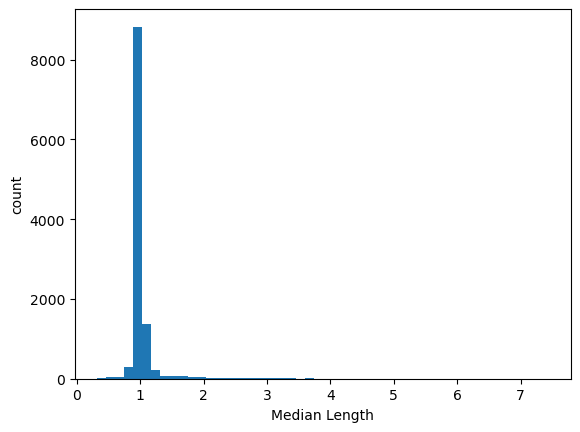

In [15]:
norm_lengths = []
for alignment, (med,norm_lengths_og) in clusters_len_norm.items():
    for norm_length in norm_lengths_og:
        norm_lengths.append(norm_length)

fig, ax = plt.subplots()
ax.hist(norm_lengths, bins=50)
ax.set_xlabel('Median Length')
ax.set_ylabel('count')

There are 479 nonzero clusters


Text(0, 0.5, 'N clusters')

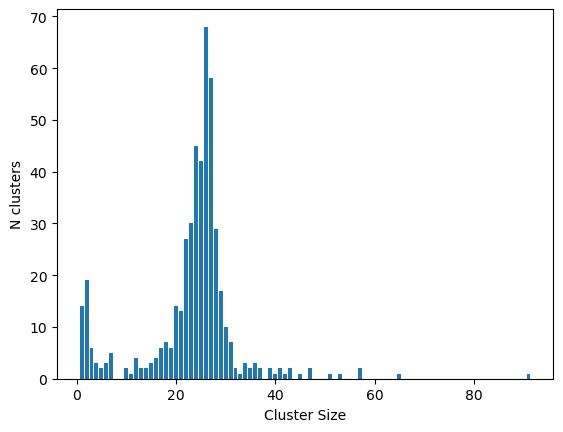

In [16]:
clust_lengths = []

min_clust_size = 4

#File to list small clusters (less than min_clust_size proteins) that are filtered out
small_cluster_filt_fname = aln_dir + os.sep + os.path.normpath('clustering/small_clusters.txt')

#File to list clusters with no SC proteins
sc_cluster_filt_fname = aln_dir + os.sep + os.path.normpath('clustering/non_sc_clusters.txt')


with(open(small_cluster_filt_fname, 'w')) as f_small:
    with(open(sc_cluster_filt_fname, 'w')) as f_no_sc:
        f_small.write('OG_cluster\tcluster_genes\n')
        f_no_sc.write('OG_cluster\tcluster_size\n')
        for og_clust, cluster in clusters_len_filt.items():
            no_sc_clust = True
            clust_len = len(cluster)
            clust_lengths.append(clust_len)
            if clust_len>0: 

                if clust_len<min_clust_size: 
                    f_small.write(og_clust+'\t[' + ",".join(cluster) + ']\n' )

                for seq in cluster: 
                    if seq.split('_')[0]=='REF':  #This means there is an S.cer protein present
                        no_sc_clust = False

                if no_sc_clust: 
                    f_no_sc.write(og_clust + '\t' + str(clust_len) + '\n')
                
            
clust_count = Counter(clust_lengths)

print('There are ' + str(len(clusters) - clust_count[0]) + ' nonzero clusters')

sizes = []
nclusts = []
for size, nclust in clust_count.items(): 
    if size>0:
        sizes.append(size)
        nclusts.append(nclust)

#Plot Histogram of all nonzero clusters
fig, ax = plt.subplots()

ax.bar(sizes, nclusts)
ax.set_xlabel('Cluster Size')
ax.set_ylabel('N clusters')



In [17]:
#List of clusters that don't have an SC protein but have more than a few proteins present.  
no_sc_clusters = pd.read_table(sc_cluster_filt_fname)
no_sc_clusters_filt = no_sc_clusters[no_sc_clusters['cluster_size']>2].sort_values(by='cluster_size', ascending=False)

#'OG5006_C1' is strange - 5 different proteins from K.mar.  The S. cer orthoglog is COB, a mitochondrial encoded Cytochrome B Oxidase, as well as an overlapping transcript, BI3 which is a Maturase which mediates splicing of an intron.  
# OG4755_C1 also has many K.mar genes and is COX2
# OG5438 is ortholog of BIO3 (biotin synthesis)
# OG5722 is ADH4 and has duplicates in a. hylecoeti

In [18]:
#Make a file to list all the clusters.  Also assigns first reference structure in a cluster as the representative (so we don't have redundant clusters)
#If there is no S. cer protein present it picks the tm_align assigned reference structure (which had a *) for the name - see clusters_ref
cluster_name_map = {}
with open(aln_dir + os.sep + ('clustering/cluster_mapping.csv'), 'w') as f_out: 
    f_out.write('primary_id,og_clust,cluster_rep,no_sc\n')
    for og_clust, cluster in clusters_len_filt.items():
        if len(cluster)>0:
            og, clust = og_clust.split('_')
            if og_clust in set(no_sc_clusters_filt['OG_cluster']):  #For clusters with no S. cer reference ##Use line with star as a reference
                seq = clusters_ref[og_clust]
                cluster_name_map[seq]=og_clust
                ref = seq.split('.')[0]
                f_out.write(og+ '_' + ref + ',' + og_clust + ',1,TRUE\n')
            else: #For clusters that have an S.cer reference
                cluster_rep = 1
                for seq in cluster: #lists same cluster multiple times if there are multiple S.cer refs present
                    if seq.split('_')[0]=='REF':
                        cluster_name_map[seq] = og_clust 
                        ref = seq.split('.')[0]
                        f_out.write(og+ '_' + ref + ',' + og_clust + ',' + str(cluster_rep) + ',FALSE\n')
                        cluster_rep = 0

In [22]:
small_cluster_filt_fname = aln_dir + os.sep + os.path.normpath('clustering/small_clusters.txt')
small_clusters = pd.read_table(small_cluster_filt_fname)


In [25]:
set(small_clusters['OG_cluster'])


{'OG1004_C0',
 'OG1060_C2',
 'OG1070_C2',
 'OG1273_C2',
 'OG1287_C2',
 'OG1310_C0',
 'OG1354_C1',
 'OG1380_C0',
 'OG1394_C1',
 'OG1468_C1',
 'OG1597_C1',
 'OG1603_C2',
 'OG1640_C1',
 'OG1714_C0',
 'OG1714_C1',
 'OG1819_C2',
 'OG1897_C0',
 'OG2048_C2',
 'OG2071_C1',
 'OG2129_C2',
 'OG2147_C0',
 'OG2227_C2',
 'OG2290_C1',
 'OG2646_C0',
 'OG2901_C0',
 'OG3000_C0',
 'OG3030_C1',
 'OG3074_C0',
 'OG3104_C1',
 'OG3151_C1',
 'OG3313_C0',
 'OG3581_C2',
 'OG4312_C0',
 'OG5006_C0',
 'OG5006_C1',
 'OG5314_C0',
 'OG5314_C1',
 'OG5735_C1',
 'OG7818_C1'}

In [31]:
clusters_len_filt[og_clust]

['eremothecium_gossypii__OG7818__40_277.pdb',
 'kluyveromyces_lactis__OG7818__50_4420.pdb',
 'lachancea_thermotolerans__OG7818__64_3371.pdb']

In [40]:
#Rename the TM-align structural alignments to match our orignal filenames. 
#Filter out
#  OGs that had too few sequences
#  peptide sequences that were too short

#pep_seq_dir = base_dir + os.sep + os.path.normpath('og_sequences/proteome')

clust_align_dir = aln_dir + os.sep + 'fasta' + os.sep
clust_align_rename_dir = aln_dir + os.sep + 'fasta_renamed' + os.sep
#clust_align_rename_all_dir = tm_align_dir + os.sep + 'fasta_renamed_all' + os.sep

cluster_mapping = pd.read_csv(aln_dir + os.sep + os.path.normpath('clustering/cluster_mapping.csv'))
cluster_mapping_dict = dict(zip(cluster_mapping['primary_id'], cluster_mapping['og_clust']))


#Option 1:  File only for representative clusters: 
for (ind, (og_ref,og_clust, cluster_rep, no_sc)) in cluster_mapping.iterrows():
    if cluster_rep == 1: 
        if not(og_clust in set(small_clusters['OG_cluster'])):
            og, clust = og_clust.split('_')
            
            full_cluster_in_fname =  clust_align_dir + og+clust + '.fa'
            
            full_cluster_in = SeqIO.parse(full_cluster_in_fname, 'fasta')
            
            clust_list = clusters_len_filt[og_clust]
            
            with open(clust_align_rename_dir+og_ref + '.tm.fasta', 'w') as f_out: 
                for record in full_cluster_in: 
                    if record.id in clust_list: 
                        f_out.write('>' + record.description + '\n')
                        f_out.write(str(record.seq) + '\n')
                        
# #Option 2: File for every cluster that is present in the main data set (and some are redundant)
# for prot_fname in os.listdir(pep_seq_dir):
#     og_ref = prot_fname.split('.')[0]
#     clust = cluster_mapping_dict[og_ref]
#     og, clust = clust.split('_')
#     shutil.copyfile(clust_align_dir + og+clust + '.fa', clust_align_rename_all_dir + og_ref + '.tm.fasta')



In [42]:
#Build a file with each proteome sequence and coding sequence for each item in the MSA

#Make big dictionary for selected coding sequences 
cds_dir = base_dir + os.sep + os.path.normpath('selected_proteins/cds') + os.sep

selected_cds_seqs = {}

for cds_file in os.listdir(cds_dir):
    cds_fasta = SeqIO.parse(cds_dir + cds_file, 'fasta')
    for record in cds_fasta: 
        selected_cds_seqs[record.id] = str(record.seq)

#Iterate through each msa 
clust_align_rename_dir = aln_dir + os.sep + 'fasta_renamed' + os.sep

seq_dir = base_dir + os.sep + 'selected_proteins' + os.sep +  'og_sequences'

for msa_file in os.listdir(clust_align_rename_dir):
    cds_file_out = seq_dir + os.sep + 'cds_tm_5' + os.sep + msa_file.split('.')[0] + '.cds.fasta'
    pep_file_out = seq_dir + os.sep + 'proteome_tm_5' + os.sep + msa_file.split('.')[0] + '.pep.fasta'
    
    msa_file_fasta = SeqIO.parse(clust_align_rename_dir + msa_file, 'fasta')
    
    with open(cds_file_out,'w') as f_out_cds: 
        with open(pep_file_out,'w') as f_out_pep:
            for record in msa_file_fasta: 
                 #Squeeze out dashes and record protein sequences
                pep_seq = ''.join([res for res in record.seq if res !='-'])
                f_out_pep.write('>' + record.id + '\n')
                f_out_pep.write(pep_seq + '\n') 
                
                #Write CDS sequences
                try:
                    f_out_cds.write('>' + record.id + '\n')
                    f_out_cds.write(selected_cds_seqs[record.id.split('.')[0]] + '\n') #Remove .pdb from name
                except KeyError:
                    print(record.id +  ' cds not found for ' + msa_file)

In [ ]:
## Thread alignments inside inside singularity container
#call_code_singularity.sh
#which calls /home/heineike_wsl2/github_s/diverse_yeast/20221206_struct_align_dnds_msa.sh
#which calls /home/heineike_wsl2/github_s/diverse_yeast/20221206_struct_align_dnds_msa.py

In [ ]:
###Sequence MSAs - also describe structural MSAs


In [29]:
## Original code in case we want to go back and do it for Oliver's alignments

# #Build a big dictionary for selected coding sequences and make a file for each og_ref name with corresponding cds

# #Make a dictionary of coding sequences
# cds_dir = base_dir + os.sep + os.path.normpath('selected_proteins/cds') + os.sep

# selected_cds_seqs = {}

# for cds_file in os.listdir(cds_dir):
#     cds_fasta = SeqIO.parse(cds_dir + cds_file, 'fasta')
#     for record in cds_fasta: 
#         selected_cds_seqs[record.id] = str(record.seq)

# #Iterate through each msa and make a codon sequence fasta (unaligned)

# seq_dir = base_dir + os.sep + 'og_sequences'

# for protein_file in os.listdir(seq_dir + os.sep + 'proteome' ):
#     cds_file_out = seq_dir + os.sep + 'cds' + os.sep + protein_file.split('.')[0] + '.cds.fasta'
    
#     protein_file_full = seq_dir + os.sep+ 'proteome' + os.sep + protein_file    
#     protein_file_fasta = SeqIO.parse(protein_file_full, 'fasta')
    
#     with open(cds_file_out,'w') as f_out_cds: 
#         for record in protein_file_fasta: 
#             try:
#                 f_out_cds.write('>' + record.id + '\n')
#                 f_out_cds.write(selected_cds_seqs[record.id] + '\n') 
#             except KeyError:
#                 print(record.id +  'cds not found for ' + protein_file)

In [30]:
##This is improved above
# #Make corresponding codon alignments. 

# #First make cds lists that contain the same sequences as the clusters
# tm_align_dir = base_dir + os.sep +  os.path.normpath('msas/structural/tm_align')
# clust_align_rename_dir = tm_align_dir + os.sep + 'fasta_renamed' + os.sep
# cds_seq_dir = base_dir + os.sep + os.path.normpath('og_sequences/cds') + os.sep
# cds_seq_dir_out = tm_align_dir + os.sep + 'cds' + os.sep



# for tm_align_fname in os.listdir(clust_align_rename_dir): 
#     tm_align = SeqIO.parse(clust_align_rename_dir + tm_align_fname, 'fasta')
#     og_ref_base = tm_align_fname.split('.')[0] 
#     cds_seq_fname = cds_seq_dir + og_ref_base + '.cds.fasta'
#     cds_seq = SeqIO.parse(cds_seq_fname, 'fasta')
#     cds_seq_lookup = {}
#     for record_cds in cds_seq: 
#         cds_seq_lookup[record_cds.id] = str(record_cds.seq)
    
#     cds_seq_fname_out = cds_seq_dir_out + og_ref_base + '.tm_present.cds.fasta'
#     with open(cds_seq_fname_out, 'w') as f_out:
#         for record in tm_align: 
#             record_id = record.id.split('.')[0]
#             try: 
#                 f_out.write('>' + record_id + '\n')
#                 f_out.write(cds_seq_lookup[record_id] + '\n')
#             except KeyError:
#                 print('No cds file for ' + record_id + ' in ' + tm_align_fname)

In [122]:
#Visualize phylogenetic trees of orthogroups that are broken apart by clustering with cluster colored in

species_table = pd.read_csv(base_dir + os.sep + 'species_selection.csv')
species_table_short = species_table.loc[species_table['Load']=='Y', ['original_genome_id', 'jacobs_name']]
spec_time_tree_2_orig = dict(zip(species_table_short['jacobs_name'], species_table_short['original_genome_id']))

out_image_dir = base_dir + os.sep + os.path.normpath('msas/structural/tm_align/clustering/cluster_trees')+ os.sep


ogs_w_subclusters = []
for og_clust in list(set(cluster_mapping['og_clust'])): 
    og, clust = og_clust.split('_')
    if clust=='C2': 
        ogs_w_subclusters.append(og)

for og in ogs_w_subclusters: #og = 'OG1004'

    cluster_names_og = {}

    for cluster in ['C1','C2']: 
        cluster_names_og[cluster] = [clust_name.split('.')[0] for clust_name in clusters[og+'_' + cluster]]

    tree_dir = base_dir + os.sep + 'msas' + os.sep + 'ogs_pep_trees'
    fname_tree = tree_dir + os.sep + og + '.mfaa.mafft.clipkit.treefile'
    t = Tree(fname_tree, format=0)  
    ts = TreeStyle()
    ts.show_leaf_name = False
    ts.show_branch_length = True

    red_node = NodeStyle()
    red_node['bgcolor'] = 'red'

    blue_node = NodeStyle()
    blue_node['bgcolor']= 'LightSteelBlue'


    for node in t.traverse(): 
        if node.is_leaf():
            (spec_time_tree, y1000_id) = node.name.split('|')
            spec_orig = spec_time_tree_2_orig[spec_time_tree]
            if spec_orig in ['saccharomyces_cerevisiae', 'candida_albicans', 'schizosaccaromyces_pombe']:  #probably none in Pombe
                print(node.name)
            else:
                new_name = spec_orig + '__' + og + '__' + y1000_id

                if new_name in cluster_names_og['C1']:
                    node.set_style(blue_node)
                elif new_name in cluster_names_og['C2']: 
                    node.set_style(red_node)

                node.name = new_name
                name_face = AttrFace("name",fsize=20)
                node.add_face(name_face, column=0, position="branch-right") 
                #convert name to primary id

    t.ladderize()
    #t.render('%%inline', tree_style=ts)
    t.render(out_image_dir + og + '.pdf', tree_style=ts)

In [ ]:
No C2: 
1603
1060 

1168 - a lot missing

C1 clusters not together: 
1354, 1394, 1468, 1597, 2071, 2290, 2357 (interesting), 3030, 3104, 3151

5735 - how did this pass our filter - not very many sequences

## Nir spotted some orthogroups in which Pombe genes are shared in multiple orthogroups

OG1	OG2
Spom_AF-Q10142-F1-model_v2.pdb	OG1242	OG4624
Spom_AF-P55306-F1-model_v2.pdb	        OG1310	OG5404
Spom_AF-O14192-F1-model_v2.pdb	OG1377	OG3639
Spom_AF-Q09755-F1-model_v2.pdb	OG2032	OG4665
Spom_AF-Q09741-F1-model_v2.pdb	OG2508	OG3801
Spom_AF-O94413-F1-model_v2.pdb	OG2588	OG2968
Spom_AF-P33075-F1-model_v2.pdb	        OG2740	OG5118
Spom_AF-Q7LKX0-F1-model_v2.pdb	OG3021	OG3909
Spom_AF-O13917-F1-model_v2.pdb	OG4317	OG4398

Oliver sees it is in the og_metadata

OGs sharing same pathway (e.g. for the first three)
Spom_AF-Q10142-F1-model_v2.pdb	OG1242	OG4624		"['SPHINGOLIPID-SYN-PWY-1']"
Spom_AF-P55306-F1-model_v2.pdb	       OG1310	OG5404		"['DETOX1-PWY']"
Spom_AF-O14192-F1-model_v2.pdb	OG1377	OG3639 	"['ALL-CHORISMATE-PWY-1', 'COMPLETE-ARO-PWY-1', 'PWY3O-351', 'PWY3O-4108', 'PWY3O-4153']"


S.pombe Q10142 is https://www.uniprot.org/uniprotkb/Q10142/entry
AUR1 Ortholog of AUR1 in S.cer

OG124 is AUR1 in S.cer

OG4624 is IPT1 in S.cer which also looks like a distant ortholog to AUR1

http://eggnog5.embl.de/#/app/results?seqid=Q10142&target_nogs=ENOG502QPQM#ENOG5028HC7_datamenu






In [30]:
#Model species info

#C. albicans
#http://www.candidagenome.org/download/sequence/C_albicans_SC5314/Assembly22/current/  
# C_albicans_SC5314_A22_current_default_coding.fasta
# C_albicans_SC5314_A22_current_default_protein.fasta
#downloaded on 20221012 and stored in
#G:\My Drive\Crick_LMS\external_data\genomes\Candida_albicans


#S. cerevisiae
#G:\My Drive\Crick_LMS\external_data\genomes\Saccharomyces_cerevisiae\S288C_reference_genome_R64-2-1_20150113
#orf_coding_all_R64-2-1_20150113.fasta
#orf_trans_all_R64-2-1_20150113.fasta

#S. pombe
#From https://www.pombase.org/data/genome_sequence_and_features/feature_sequences/ on 20221012
#cds.fa 
#peptide.fa  
#both last modified 2022-10-12 03:26
#Stored at
#G:\My Drive\Crick_LMS\external_data\genomes\Schizosaccharomyces_pombe